In [35]:
"""
Created by Tetsu Haruyama
"""

import warnings
import numpy as np
import pandas as pd
from scipy.stats import norm,chi2
import statsmodels.api as sm
from statsmodels.base.model import LikelihoodModel,LikelihoodModelResults,ResultMixin
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.numdiff import approx_fprime

#%% GenericLikelihoodModel_TobitTruncreg

class GenericLikelihoodModel_TobitTruncreg(LikelihoodModel):
    """
    This is based on GenericLikelihoodModel of statsmodels (0.9.0).
    The modified part is indecated: see the following
        * `cov_type`
        * `genericmlefit`
    The aim of this class: to make it possible to use GenericLikelihoodModelResults_TobitTruncreg (see below)
    """
    def __init__(self, endog, exog=None, loglike=None, score=None,
                 hessian=None, missing='none', extra_params_names=None,
                 **kwds):

        if loglike is not None:
            self.loglike = loglike
        if score is not None:
            self.score = score
        if hessian is not None:
            self.hessian = hessian

        self.__dict__.update(kwds)

        super(GenericLikelihoodModel_TobitTruncreg, self).__init__(endog, exog,
                                                     missing=missing)

        if exog is not None:
            self.nparams = (exog.shape[1] if np.ndim(exog) == 2 else 1)

        if extra_params_names is not None:
            self._set_extra_params_names(extra_params_names)

    def _set_extra_params_names(self, extra_params_names):
        # check param_names
        if extra_params_names is not None:
            if self.exog is not None:
                self.exog_names.extend(extra_params_names)
            else:
                self.data.xnames = extra_params_names

        self.nparams = len(self.exog_names)

    def initialize(self):
        """
        Initialize (possibly re-initialize) a Model instance. For
        instance, the design matrix of a linear model may change
        and some things must be recomputed.
        """
        if not self.score:
            self.score = lambda x: approx_fprime(x, self.loglike)
            if not self.hessian:
                pass
        else:
            if not self.hessian:
                pass

        if self.exog is not None:
            er = np.linalg.matrix_rank(self.exog)
            self.df_model = float(er - 1)
            self.df_resid = float(self.exog.shape[0] - er)
        else:
            self.df_model = np.nan
            self.df_resid = np.nan
        super(GenericLikelihoodModel_TobitTruncreg, self).initialize()

    def expandparams(self, params):
        """
        expand to full parameter array when some parameters are fixed

        Parameters
        ----------
        params : array
            reduced parameter array

        Returns
        -------
        paramsfull : array
            expanded parameter array where fixed parameters are included

        Notes
        -----
        Calling this requires that self.fixed_params and self.fixed_paramsmask
        are defined.

        *developer notes:*

        This can be used in the log-likelihood to ...

        this could also be replaced by a more general parameter
        transformation.

        """
        paramsfull = self.fixed_params.copy()
        paramsfull[self.fixed_paramsmask] = params
        return paramsfull

    def reduceparams(self, params):
        """Reduce parameters"""
        return params[self.fixed_paramsmask]

    def loglike(self, params):
        """Log-likelihood of model at params"""
        return self.loglikeobs(params).sum(0)

    def nloglike(self, params):
        """Negative log-likelihood of model at params"""
        return -self.loglikeobs(params).sum(0)

    def loglikeobs(self, params):
        """Log-likelihood of individual observations at params"""
        return -self.nloglikeobs(params)

    def score(self, params):
        """
        Gradient of log-likelihood evaluated at params
        """
        kwds = {}
        kwds.setdefault('centered', True)
        return approx_fprime(params, self.loglike, **kwds).ravel()

    def score_obs(self, params, **kwds):
        """
        Jacobian/Gradient of log-likelihood evaluated at params for each
        observation.
        """
        kwds.setdefault('centered', True)
        return approx_fprime(params, self.loglikeobs, **kwds)

    def hessian(self, params):
        """
        Hessian of log-likelihood evaluated at params
        """
        from statsmodels.tools.numdiff import approx_hess
        # need options for hess (epsilon)
        return approx_hess(params, self.loglike)

    def fit(self, cov_type=None, start_params=None, method='nm', maxiter=500, full_output=1,   # modified
            disp=1, callback=None, retall=0, **kwargs):
        """
        Fit the model using maximum likelihood.

        The rest of the docstring is from
        statsmodels.LikelihoodModel.fit
        """
        if cov_type is None:          # modified
            cov_type = 'nonrobust'    # modified

        if start_params is None:
            if hasattr(self, 'start_params'):
                start_params = self.start_params
            else:
                start_params = 0.1 * np.ones(self.nparams)

        fit_method = super(GenericLikelihoodModel_TobitTruncreg, self).fit
        mlefit = fit_method(cov_type=cov_type, start_params=start_params,   # modified
                            method=method, maxiter=maxiter,
                            full_output=full_output,
                            disp=disp, callback=callback, **kwargs)

        # addition for modifincation starts ------------------------------------
        # if 'Truncreg' in str(self.model.__class__):
        if 'Truncreg' in str(self.__class__):
            genericmlefit = GenericLikelihoodModelResults_Truncreg(self, mlefit, cov_type)
        elif 'Tobit' in str(self.__class__):
            genericmlefit = GenericLikelihoodModelResults_Tobit(self, mlefit, cov_type)
        else:
            pass
        # addition for modifincation ends --------------------------------------

        exog_names = [] if (self.exog_names is None) else self.exog_names
        k_miss = len(exog_names) - len(mlefit.params)
        if not k_miss == 0:
            if k_miss < 0:
                self._set_extra_params_names(['par%d' % i
                                              for i in range(-k_miss)])
            else:
                import warnings
                warnings.warn('more exog_names than parameters', ValueWarning)

        return genericmlefit
#-----

#%% CommonAttributes_TobitTruncreg

class CommonAttributes_TobitTruncreg(object):
    # # Wald Test - all slopes=0
    @cache_readonly
    def wald_test_all_slopes(self):
        _mat = np.eye(len(self.params))[1:-1,:]
        return self.wald_test(_mat)

    @cache_readonly
    def prsquared(self):
        """
        McFadden's pseudo-R-squared. `1 - (llf / llnull)`
        """
        return 1 - self.llf/self.llnull

    @cache_readonly
    def llr(self):
        """
        Likelihood ratio chi-squared statistic; `-2*(llnull - llf)`
        under H0: all coefficients excluding constnat is zero
        """
        return -2*(self.llnull - self.llf)

    @cache_readonly
    def llr_pvalue(self):
        """
        p-value of likelihood ratio chi-squared statistic; `-2*(llnull - llf)`
        with degrees of freedom `df_model`
        under H0: all coefficients excluding constnat is zero
        """
        return chi2.sf(self.llr, self.df_model)

    @cache_readonly
    def llnull(self):
        """
        Value of loglikelihood with an Intercept only (no slope coefficients)
        """
        return self.result_null.llf

    def set_null_options(self, llnull=None, attach_results=True, **kwds):
        """set fit options for Null (constant-only) model

        This resets the cache for related attributes which is potentially
        fragile. This only sets the option, the null model is estimated
        when llnull is accessed, if llnull is not yet in cache.

        Parameters
        ----------
        llnull : None or float
            If llnull is not None, then the value will be directly assigned to
            the cached attribute "llnull".
        attach_results : bool
            Sets an internal flag whether the results instance of the null
            model should be attached. By default without calling this method,
            thenull model results are not attached and only the loglikelihood
            value llnull is stored.
        kwds : keyword arguments
            `kwds` are directly used as fit keyword arguments for the null
            model, overriding any provided defaults.

        Returns
        -------
        no returns, modifies attributes of this instance

        """
        self._cache.pop('llnull', None)
        self._cache.pop('llr', None)
        self._cache.pop('llr_pvalue', None)
        self._cache.pop('prsquared', None)
        if hasattr(self, 'result_null'):  # Tetsu
            del self.result_null          # Tetsu

        if llnull is not None:
            self._cache['llnull'] = llnull
        self._attach_nullmodel = attach_results
        self._optim_kwds_null = kwds

    @cache_readonly
    def result_null(self):
        """
        Value of loglikelihood with an Intercept only (no slope coefficients)
        """
        model = self.model
        kwds = model._get_init_kwds().copy()
        for key in getattr(model, '_null_drop_keys', []):
            del kwds[key]

        # the following lines are modified
        if 'Truncreg' in str(model.__class__):
            mod_null = model.__class__(model.endog, np.ones(self.nobs), left=model.left, right=model.right, **kwds)
        elif 'Tobit' in str(model.__class__):
            mod_null = model.__class__(model.endog, np.ones(self.nobs), cens=model.cens, left=model.left, right=model.right, **kwds)
        else:
            pass

        optim_kwds = getattr(self, '_optim_kwds_null', {}).copy()

        if 'start_params' in optim_kwds:

            sp_null = optim_kwds.pop('start_params')
        elif hasattr(model, '_get_start_params_null'):

            sp_null = model._get_start_params_null()
        else:
            sp_null = None

        opt_kwds = dict(method='bfgs', warn_convergence=False, maxiter=10000,disp=0)
        opt_kwds.update(optim_kwds)

        if optim_kwds:
            res_null = mod_null.fit(start_params=sp_null, **opt_kwds)
        else:
            res_null = mod_null.fit(start_params=sp_null, method='nm',
                                    warn_convergence=False,
                                    maxiter=10000, disp=0)

        if getattr(self, '_attach_nullmodel', False) is not False:
            self.res_null = res_null

        return res_null
#-----

#%% AdditionalAttributes_Truncreg

class AdditionalAttributes_Truncreg(object):
    @cache_readonly
    def fittedvalues(self):
        """
        y_hat (Linear fitted values)
        """
        return self.exog @ self.params[:-1].T

    # residuals
    @cache_readonly
    def resid(self):
        """
        Residuals = y - y_hat
        """
        return self.endog - self.fittedvalues


    @cache_readonly
    def fitted_endog(self):
        """
        E(y|x, cond)
            cond for left-truncated: y > left-truncated value
            cond for left-truncated: y < right-truncated value
            cond for left- & right-truncated: left-truncated value < y < right-truncated value
        Non-linear fitted endog variables (conditional expectations)
        But, this attribute may be that useful
        """
        s = self.params[-1]
        sigma = np.exp(s)
        Xb = self.fittedvalues
        _l = self.model.left
        _r = self.model.right

        if ~np.isneginf(_l) & np.isposinf(_r):
            first_term = Xb*norm.cdf(Xb, loc=_l, scale=sigma)
            second_term = sigma*norm.pdf(Xb, loc=_l, scale=sigma)
            return first_term + second_term

        elif np.isneginf(_l) & ~np.isposinf(_r):
            first_term = Xb*norm.sf(Xb, loc=_r, scale=sigma)
            second_term = sigma*norm.pdf(Xb, loc=_r, scale=sigma)
            return first_term - second_term

        elif ~np.isneginf(_l) & ~np.isposinf(_r):
            first_term = Xb*norm.cdf(Xb, loc=_l, scale=sigma)
            second_term = Xb*norm.cdf(Xb, loc=_r, scale=sigma)
            third_term = sigma*( norm.pdf(Xb, loc=_l, scale=sigma) - norm.pdf(Xb, loc=_r, scale=sigma) )
            return first_term - second_term + third_term

        else:
            warnings.warn('\n\n**********************************************************************\n\n'+
                          'Equivalent to untruncated Maximum Likelihood Estimation\n\n'+
                          '**********************************************************************\n')

#-----

#%% AdditionalAttributes_Tobit

class AdditionalAttributes_Tobit(object):
    @cache_readonly
    def fittedvalues(self):
        """
        y_hat (linear fiited latent variable)
        """
        return self.exog @ self.params[:-1].T

    # residuals
    @cache_readonly
    def resid(self):
        """
        Residuals = y - y_hat
        """
        return self.endog - self.fittedvalues

    # non-linear fitted endog variables (conditional expectations)
    @cache_readonly
    def fitted_endog(self):
        """
        E(y|x, cond)
            cond for left-truncated: y > left-truncated value
            cond for left-truncated: y < right-truncated value
            cond for left- & right-truncated: left-truncated value < y < right-truncated value
        Non-linear fitted endog variables (conditional expectations)
        """
        s = self.params[-1]
        sigma = np.exp(s)
        Xb = self.fittedvalues
        _l = self.model.left
        _r = self.model.right
        check_left = self.model.cens.unique().min()
        check_right = self.model.cens.unique().max()

        if (check_left == -1) & (check_right == 0):
            first_term = (Xb-_l)*norm.cdf(Xb, loc=_l, scale=sigma)
            second_term = sigma*norm.pdf(Xb, loc=_l, scale=sigma)
            return _l + first_term + second_term

        elif (check_left == 0) & (check_right == 1):
            first_term = (Xb-_r)*norm.sf(Xb, loc=_r, scale=sigma)
            second_term = sigma*norm.pdf(Xb, loc=_r, scale=sigma)
            return _r + first_term - second_term

        elif (check_left == -1) & (check_right == 1):
            first_term = (Xb-_l)*norm.cdf(Xb, loc=_l, scale=sigma)
            second_term = (Xb-_r)*norm.cdf(Xb, loc=_r, scale=sigma)
            third_term = sigma*( norm.pdf(Xb, loc=_l, scale=sigma) - norm.pdf(Xb, loc=_r, scale=sigma) )
            return _l + first_term - second_term + third_term

        else:
            warnings.warn('\n\n**********************************************************************\n\n'+
                          'Equivalent to fitted_endog of uncensored Maximum Likelihood Estimation\n\n'+
                          '**********************************************************************\n')


    # censoring
    @cache_readonly
    def obs(self):
        """
        (no of obs, no of uncensored obs, no of left-censored obs, no of right-censored obs)
        """
        censor = self.model.cens
        num_minus_1 = len(censor[censor == -1])
        num_0 = len(censor[censor == 0])
        num_1 = len(censor[censor == 1])
        uncensored = num_0
        left_censored = num_minus_1
        right_censored = num_1
        return self.nobs,uncensored,left_censored,right_censored


#-----

#%% GenericLikelihoodModelResults_Truncreg

class GenericLikelihoodModelResults_Truncreg(LikelihoodModelResults,
                                             ResultMixin,
                                             CommonAttributes_TobitTruncreg,
                                             AdditionalAttributes_Truncreg):
    """
    This is based on GenericLikelihoodModelResults of statsmodels (0.9.0).
    Some attributes are added.

    Attributes
    ----------
    aic : float
        Akaike information criterion.  -2*(`llf` - p) where p is the number
        of regressors including the intercept.
    bic : float
        Bayesian information criterion. -2*`llf` + ln(`nobs`)*p where p is the
        number of regressors including the intercept.
    bse : array
        The standard errors of the coefficients.
    df_resid : float
        See model definition.
    df_model : float
        See model definition.
    fitted_values : array
        Linear predictor XB.
    llf : float
        Value of the loglikelihood
    llnull : float
        Value of the constant-only loglikelihood
    llr : float
        Likelihood ratio chi-squared statistic; -2*(`llnull` - `llf`)
    llr_pvalue : float
        The chi-squared probability of getting a log-likelihood ratio
        statistic greater than llr.  llr has a chi-squared distribution
        with degrees of freedom `df_model`.
    prsquared : float
        McFadden's pseudo-R-squared. 1 - (`llf`/`llnull`)
    result_null:
        result under H0: all slope coefficients are zero
    """

    def __init__(self, model, mlefit, cov_type):
        self.model = model
        self.endog = model.endog
        self.exog = model.exog
        self.nobs = model.endog.shape[0]
        self.cov_type = cov_type         # added

        if hasattr(model, 'df_model'):
            self.df_model = model.df_model
        else:
            self.df_model = len(mlefit.params)

            self.model.df_model = self.df_model

        if hasattr(model, 'df_resid'):
            self.df_resid = model.df_resid
        else:
            self.df_resid = self.endog.shape[0] - self.df_model

            self.model.df_resid = self.df_resid

        self._cache = {}
        self.__dict__.update(mlefit.__dict__)


    def summary(self, yname=None, xname=None, title=None, alpha=.05):
        """Summarize the Regression Results

        Parameters
        ----------
        yname : string, optional
            Default is `y`
        xname : list of strings, optional
            Default is `var_##` for ## in p the number of regressors
        title : string, optional
            Title for the top table. If not None, then this replaces the
            default title
        alpha : float
            significance level for the confidence intervals

        Returns
        -------
        smry : Summary instance
            this holds the summary tables and text, which can be printed or
            converted to various output formats.

        See Also
        --------
        statsmodels.iolib.summary.Summary : class to hold summary results
        """

        # if 'truncreg' in str(self.model.__module__):
        top_left = [('Dep. Variable:', None),
                    ('Model:', None),
                    ('Method:', ['Maximum Likelihood']),
                    ('Date:', None),
                    ('Time:', None),
                    ('No. Observations:', None),
                    ('Df Residuals:', None),
                    ('Df Model:', None),
                    ]

        top_right = [('Pseudo R-squ:',["{:.3f}".format(self.prsquared)]),
                     ('Log-Likelihood:', ["{:.1f}".format(self.llf)]),
                     ('LL-Null:', ["{:.1f}".format(self.llnull)]),
                     ('LL-Ratio:', ["{:.1f}".format(self.llr)]),
                     ('LLR p-value:', ["{:.3f}".format(self.llr_pvalue)]),
                     ('AIC:', ["{:.1f}".format(self.aic)]),
                     ('BIC:', ["{:.1f}".format(self.bic)]),
                     ('Covariance Type:', [self.cov_type]),
                     ]

        if title is None:
            title = self.model.__class__.__name__ + ' ' + "Regression Results"

        # create summary table instance
        from statsmodels.iolib.summary import Summary
        smry = Summary()
        smry.add_table_2cols(self, gleft=top_left, gright=top_right,
                             yname=yname, xname=xname, title=title)
        smry.add_table_params(self, yname=yname, xname=xname, alpha=alpha,
                              use_t=self.use_t)

        return smry
#-----

#%% GenericLikelihoodModelResults_Tobit

class GenericLikelihoodModelResults_Tobit(LikelihoodModelResults,
                                          ResultMixin,
                                          CommonAttributes_TobitTruncreg,
                                          AdditionalAttributes_Tobit):
    """
    This is based on GenericLikelihoodModelResults of statsmodels (0.9.0).
    Some attributes are added.

    Attributes
    ----------
    aic : float
        Akaike information criterion.  -2*(`llf` - p) where p is the number
        of regressors including the intercept.
    bic : float
        Bayesian information criterion. -2*`llf` + ln(`nobs`)*p where p is the
        number of regressors including the intercept.
    bse : array
        The standard errors of the coefficients.
    df_resid : float
        See model definition.
    df_model : float
        See model definition.
    fitted_values : array
        Linear predictor XB.
    llf : float
        Value of the loglikelihood
    llnull : float
        Value of the constant-only loglikelihood
    llr : float
        Likelihood ratio chi-squared statistic; -2*(`llnull` - `llf`)
    llr_pvalue : float
        The chi-squared probability of getting a log-likelihood ratio
        statistic greater than llr.  llr has a chi-squared distribution
        with degrees of freedom `df_model`.
    prsquared : float
        McFadden's pseudo-R-squared. 1 - (`llf`/`llnull`)
    result_null:
        result under H0: all slope coefficients are zero
    """

    def __init__(self, model, mlefit, cov_type):
        self.model = model
        self.endog = model.endog
        self.exog = model.exog
        self.nobs = model.endog.shape[0]
        self.cov_type = cov_type         # added

        if hasattr(model, 'df_model'):
            self.df_model = model.df_model
        else:
            self.df_model = len(mlefit.params)

            self.model.df_model = self.df_model

        if hasattr(model, 'df_resid'):
            self.df_resid = model.df_resid
        else:
            self.df_resid = self.endog.shape[0] - self.df_model

            self.model.df_resid = self.df_resid

        self._cache = {}
        self.__dict__.update(mlefit.__dict__)


    def summary(self, yname=None, xname=None, title=None, alpha=.05):
        """Summarize the Regression Results

        Parameters
        ----------
        yname : string, optional
            Default is `y`
        xname : list of strings, optional
            Default is `var_##` for ## in p the number of regressors
        title : string, optional
            Title for the top table. If not None, then this replaces the
            default title
        alpha : float
            significance level for the confidence intervals

        Returns
        -------
        smry : Summary instance
            this holds the summary tables and text, which can be printed or
            converted to various output formats.

        See Also
        --------
        statsmodels.iolib.summary.Summary : class to hold summary results
        """

        top_left = [('Dep. Variable:', None),
                    # ('Model:', None),
                    ('Method:', ['Maximum Likelihood']),
                    # ('Date:', None),
                    # ('Time:', None),
                    ('No. Observations:', None),
                    ('No. Uncensored Obs:', ["{:.0f}".format(self.obs[1])]),
                    ('No. Left-censored Obs:', ["{:.0f}".format(self.obs[2])]),
                    ('No. Right-censored Obs:', ["{:.0f}".format(self.obs[3])]),
                    ('Df Residuals:', None),
                    ('Df Model:', None),
                    ]

        top_right = [('Pseudo R-squ:',["{:.3f}".format(self.prsquared)]),
                     ('Log-Likelihood:', ["{:.1f}".format(self.llf)]),
                     ('LL-Null:', ["{:.1f}".format(self.llnull)]),
                     ('LL-Ratio:', ["{:.1f}".format(self.llr)]),
                     ('LLR p-value:', ["{:.3f}".format(self.llr_pvalue)]),
                     ('AIC:', ["{:.1f}".format(self.aic)]),
                     ('BIC:', ["{:.1f}".format(self.bic)]),
                     ('Covariance Type:', [self.cov_type]),
                     ]

        if title is None:
            title = self.model.__class__.__name__ + ' ' + "Regression Results"

        # create summary table instance
        from statsmodels.iolib.summary import Summary
        smry = Summary()
        smry.add_table_2cols(self, gleft=top_left, gright=top_right,
                             yname=yname, xname=xname, title=title)
        smry.add_table_params(self, yname=yname, xname=xname, alpha=alpha,
                              use_t=self.use_t)

        return smry
#-----

# EOF

In [36]:
"""
Created by Tetsu Haruyama
"""

import warnings
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
#from py4etrics.base_for_models import GenericLikelihoodModel_TobitTruncreg

class Tobit(GenericLikelihoodModel_TobitTruncreg):
    """
    Create a Seires or array (to be used for "<censor>" below)
           -1: left-censored
            0: uncensored
            1: right-censored

    Method 1:
    Tobit(endog, exog, cens=<censor>, left=<0>, right=<0>).fit()
    endog = dependent variable
    exog = independent variable (add constant if needed)
    cens = see above
    left = the threshold value for left-censoring (default:0)
        　　(This becomes effective only if -1 is set in <censor>)
    right = the threshold value for right-censoring (default:0)
        　　(This becomes effective only if 1 is set in <censor>)
          
    Method 2:
    formula = 'y ~ 1 + x'
    Tobit.from_formula(formula, cens=<censor>, left=<0>, right=<0>, data=<DATA>).fit()
  
  """

    def __init__(self, endog, exog, cens, left=None, right=None, **kwds):
        super(Tobit, self).__init__(endog, exog, **kwds)
        self.cens = cens
        if left is None:
            left = 0
        self.left = left
        if right is None:
            right = 0
        self.right = right

    def loglikeobs(self, params): # see _tobit()
#     def loglike(self, params): # see _tobit()

        s = params[-1]
        beta = params[:-1]

        def _tobit(y, x, z, left, right, beta, s):
            if ( ~np.isin(z,[-1,0,1]) ).any():
                warnings.warn('\n\n***************************************************\n\n'+
                              'There are values other than [-1,0,1] in a column for cens\n\n'+
                             '***************************************************\n')

            # indicators
            left_on  = np.where(z==-1, 1, 0)
            mid_on   = np.where(z== 0, 1, 0)
            right_on = np.where(z== 1, 1, 0)

            Xb = np.dot(x, beta)

            # Eqn 5 of https://cran.r-project.org/web/packages/censReg/vignettes/censReg.pdf
            # scale=np.exp(s)
            left_mle  = left_on *  norm.logcdf( (left-Xb)  / np.exp(s) )
            mid_mle   = mid_on * ( norm.logpdf( (y-Xb)     / np.exp(s) ) - s )
            right_mle = right_on * norm.logcdf( (Xb-right) / np.exp(s) )
            
            return left_mle + mid_mle + right_mle  #  loglikeobs()                        
#             return (left_mle+mid_mle+right_mle).sum()  #  loglike()

        return _tobit(self.endog, self.exog, self.cens, self.left, self.right, beta, s)

    def fit(self, cov_type='nonrobust', start_params=None, maxiter=10000, maxfun=10000, **kwds):
        
        # add sigma for summary
        if 'Log(Sigma)' not in self.exog_names:  # ML Case 1 is used
            self.exog_names.append('Log(Sigma)')
        else:
            pass
        
        # initial guess
        res = sm.OLS(self.endog, self.exog).fit()
        ols_params = res.params
        ols_sigma = np.log(np.std(res.resid))
        
        # option
        if start_params == None:
            start_params = np.append(ols_params, ols_sigma)

        res = super(Tobit, self).fit(cov_type=cov_type, start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun, **kwds)
        return res

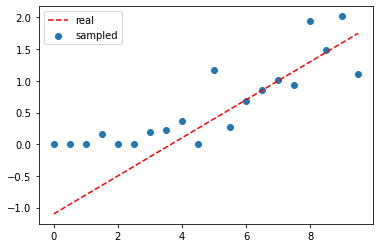

In [37]:
import numpy as np
import scipy
import math
import random
random.seed(32)
from matplotlib import pyplot as plt
x = np.arange(0,10,0.5)

y_real = np.array([i*0.3-1.1 for i in x])
y_sampled = np.array([(i+random.gauss(0,0.4)) for i in y_real])
y_sampled_truncated = np.where(y_sampled<0,0,y_sampled)
plt.plot(x,y_real,label='real',ls='--',c='r')
plt.scatter(x,y_sampled_truncated,label='sampled')
plt.legend()
plt.show()

In [38]:
x = x.reshape(-1,1)
x = np.concatenate([x,np.ones((len(x),1))],axis=1)
y_sampled_truncated = y_sampled_truncated.reshape(-1,1)

In [39]:
# running the regression using the normal equation
beta = scipy.linalg.inv(x.T@x)@(x.T)@y_sampled_truncated
beta

array([[ 0.19302975],
       [-0.29385029]])

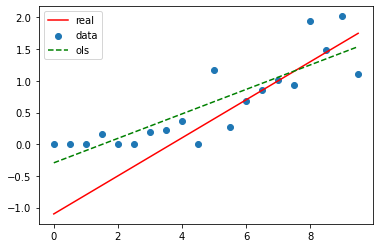

In [40]:
pred_y = x@beta

plt.plot(x[:,0].ravel(),y_real,label='real',ls='-',c='r')
plt.scatter(x[:,0].ravel(),y_sampled_truncated,label='data')
plt.plot(x[:,0].ravel(),pred_y,label='ols',c='g',ls='--')
plt.legend()
plt.show()

In [41]:
tob = Tobit(y_sampled,x,0)
tob_fit = tob.fit()

Optimization terminated successfully.
         Current function value: 0.511606
         Iterations: 42
         Function evaluations: 73


In [42]:
tob_fit.summary()

TypeError: 'int' object is not subscriptable

In [25]:
tob_fit.predict()

NotImplementedError: 

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, MultiOutputMixin
from sklearn.linear_model._base import LinearModel, _preprocess_data, _check_sample_weight,_rescale_data
from sklearn.utils.validation import check_is_fitted
#from sklearn.utils.parallel import delayed, Parallel

from scipy import linalg
from scipy import optimize
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.sparse as sp

import numpy as np

class Tobit(MultiOutputMixin, RegressorMixin, LinearModel):
    ''' 
    Simple implementation of tobit regression.

    Uses the loglikehood function as a loss.

    Doesn't accept sparse matrix for now.
    
    '''
    def __init__(self, *, fit_intercept=True, copy_X=True, n_jobs=None, positive=False):
        self.fit_intercept = fit_intercept
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive
    
    def fit(self, X, y, sample_weight=None):
        """
        Fit linear model.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values. Will be cast to X's dtype if necessary.

        sample_weight : array-like of shape (n_samples,), default=None
            Individual weights for each sample.

            .. versionadded:: 0.17
               parameter *sample_weight* support to LinearRegression.

        Returns
        -------
        self : object
            Fitted Estimator.
        """

        #self._validate_params()

        n_jobs_ = self.n_jobs

        accept_sparse = False if self.positive else ["csr", "csc", "coo"]

        X, y = self._validate_data(
            X, y, accept_sparse=accept_sparse, y_numeric=True, multi_output=True
        )

        sample_weight = _check_sample_weight(
            sample_weight, X, dtype=X.dtype
        )

        X, y, X_offset, y_offset, X_scale = _preprocess_data(
            X,
            y,
            fit_intercept=self.fit_intercept,
            copy=self.copy_X,
            sample_weight=sample_weight,
        )

        # Sample weight can be implemented via a simple rescaling.
        X, y = _rescale_data(X, y, sample_weight)

        # fitting with the loglikelihood function
        self.coef_, _, self.rank_, self.singular_ = linalg.lstsq(X, y)
        self.coef_ = self.coef_.T

        if y.ndim == 1:
            self.coef_ = np.ravel(self.coef_)
        self._set_intercept(X_offset, y_offset, X_scale)
        return self


def tobit_loss(threshold,sigma,y_real,y_pred):
    log_lkhd_left = np.log((1/sigma)*(y_real-y_pred)/sigma)
    log_lkhd_right = np.log((threshold-y_pred)/sigma)
    return np.sum(log_lkhd_left) + np.sum(log_lkhd_right)

In [58]:
import numpy as np
import scipy
import math
import random
random.seed(32)
from matplotlib import pyplot as plt
x = np.arange(0,10,0.5)

y_real = np.array([i*0.3-1.1 for i in x])
y_sampled = np.array([(i+random.gauss(0,0.4)) for i in y_real])
y_sampled_truncated = np.where(y_sampled<0,0,y_sampled)

x = x.reshape(-1,1)
y_sampled_truncated = y_sampled_truncated.reshape(-1,1)

reg_tobit = Tobit()
reg_tobit.fit(x,y_sampled_truncated)

ValueError: not enough values to unpack (expected 3, got 2)